# 通常の信頼区間とベイズ版信用区間の比較

In [1]:
using Distributions
using Roots
using Plots
using StatsFuns: logistic, logit

# \approx TAB → ≈
# \lessapprox TAB → ⪅
x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)

In [2]:
# Bernoulli分布モデルでの通常の信頼区間

"""P値函数"""
function pvalue(n, p, k)
    bin = Binomial(n, p)
    p0 = pdf(bin, k)
    s = sum(pdf(bin, j) for j in support(bin) if pdf(bin, j) ⪅ p0)
    min(1, s)
end

"""信頼区間函数"""
function confidence_interval(n, k; α = 0.05)
    f(t) = pvalue(n, logistic(t), k) - α
    CI = logistic.(find_zeros(f, -10, 10))
end

confidence_interval

In [3]:
# Bernoulli分布モデルと共役事前分布に関するベイズ版信用区間

"""事後分布"""
posterior_dist(n, k; a = 0.5, b = 0.5) = Beta(a + k, b + n - k)

"""ベイズ版P値函数"""
function pvalue_bayes(n, p, k; a = 0.5, b = 0.5)
    posterior = posterior_dist(n, k; a, b)
    v0 = logpdf(posterior, p)
    f(t) = logpdf(posterior, logistic(t)) - v0
    m = mode(posterior)
    if p ≤ m
        q = logistic(find_zero(f, logit(m) + 1))
        s = cdf(posterior, p) + ccdf(posterior, q)
    else
        q = logistic(find_zero(f, logit(m) - 1))
        s = cdf(posterior, q) + ccdf(posterior, p)
    end
    min(1, s)
end

"""信用区間函数"""
function credible_interval(n, k; α = 0.05, a = 0.5, b = 0.5)
    g(t) = pvalue_bayes(n, logistic(t), k; a, b) - α
    posterior = posterior_dist(n, k; a, b)
    m = mode(posterior)
    L, R = max(-50, logit(m) - 5), min(50, logit(m) + 5)
    CI = logistic.(find_zeros(g, L, R))  
end

credible_interval

In [4]:
# 信頼区間とベイズ版信用区間の比較

function plot_cis(n, k; α = 0.05, a = 0.5, b = 0.5)
    confint = confidence_interval(n, k; α)
    credint = credible_interval(n, k; α, a, b)

    bin = Binomial(n, k/n)
    μ, σ = mean(bin)/n, std(bin)/n
    p = range(max(1e-8, μ - 3.5σ), min(1-1e-8, μ + 4σ); length=400)
    plot(p, p -> pvalue_bayes(n, p, k); label="Bayesian p-value function", c = 1, lw=1.5)
    plot!(p, p -> pvalue(n, p, k); label="ordinary p-value function", c = 2, ls=:dash, lw=1.5)
    plot!(; ytick=0:0.05:1)
    plot!(credint, fill( 0.005, 2); label="Baysian credible interval", c=:blue, lw=2)
    plot!(confint, fill(-0.005, 2); label="confidence interval", c=:red, ls=:dash, lw=2)
    title!("n = $n, k = $k, α = $α, prior = Beta($a, $b)"; titlefontsize=10)
end

plot_cis (generic function with 1 method)

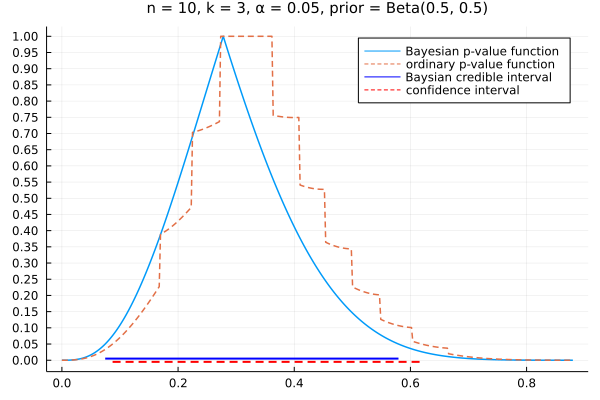

In [5]:
plot_cis(10, 3)

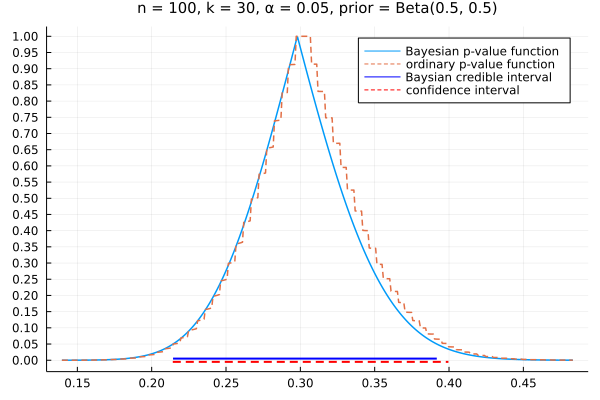

In [6]:
plot_cis(100, 30)

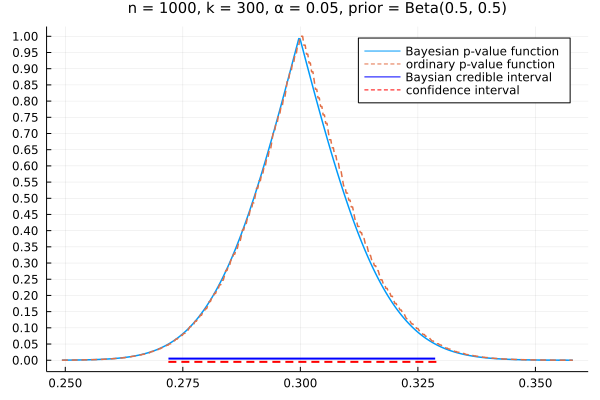

In [7]:
plot_cis(1000, 300)

$n$ が大きくするにつれて数値的に通常の信頼区間とベイズ版信用区間は数値的によく一致するようになる。

このようなことはシンプルなモデルでは一般的に広く成立している.